In [1]:
# Import necessary packages
import keras
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import cv2
import sklearn
import shap
import os
import seaborn as sns
import time
import pickle
import tensorflow as tf
sns.set()

# This sets a common size for all the figures we will draw.
plt.rcParams['figure.figsize'] = [10, 7]

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


**IMPORTANT: In order to correctly execute this code, we use the images from a folder called deliverable_images which we call thoughout the code. You must download these images (which takes around an hour) from https://www.kaggle.com/datasets/nih-chest-xrays/sample**

**IMPORTANT: the code developed by us is denoted by the comment "### OUR CODE ###"**

# Data Processing
we will work with chest x-ray images taken from the public [ChestX-ray8 dataset](https://arxiv.org/abs/1705.02315).

In [2]:
csv_file = "sample_labels.csv"
df = pd.read_csv(csv_file)
df_use = df[['Image Index', 'Finding Labels', 'Patient ID']]
df_use.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5606 entries, 0 to 5605
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Image Index     5606 non-null   object
 1   Finding Labels  5606 non-null   object
 2   Patient ID      5606 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 131.5+ KB


In [3]:
# one-hot encode Finding Labels
label_set = df_use['Finding Labels'].str.split('|').apply(set) - {'No Finding'}
labels = pd.Series(label_set).str.join('|').str.get_dummies()
df_use = pd.concat([df_use, labels], axis=1)
df_use.drop(['Finding Labels'], axis=1, inplace=True)
df_use.head()

,Image Index,Patient ID,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000013_005.png,13,0,0,0,0,0,1,0,0,1,0,0,1,0,1
1,00000013_026.png,13,0,1,0,0,0,1,0,0,0,0,0,0,0,0
2,00000017_001.png,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,00000030_001.png,30,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,00000032_001.png,32,0,1,0,1,1,0,0,0,0,0,0,0,0,0


It is worth noting that our dataset contains multiple images for each patient. This could be the case, for example, when a patient has taken multiple X-ray images at different times during their hospital visits. In our data splitting, we ensure that the split is done on the patient level so that there is no data "leakage" between the train, validation, and test datasets.

In [4]:
### OUR CODE ###
from sklearn.model_selection import train_test_split

patients = df_use['Patient ID'].unique()
train_patients, test_patients = train_test_split(patients, test_size=0.2, random_state=28)
train_patients, val_patients = train_test_split(train_patients, test_size=0.2, random_state=28)
print("Number of patients in training set: {}".format(len(train_patients)))
print("Number of patients in validation set: {}".format(len(val_patients)))

train_df = df_use[df_use['Patient ID'].isin(train_patients)]
valid_df = df_use[df_use['Patient ID'].isin(val_patients)]
test_df = df_use[df_use['Patient ID'].isin(test_patients)]

print("Train proportion: {}".format(len(train_df)/len(df_use)))
print("Validation proportion: {}".format(len(valid_df)/len(df_use)))
print("Test proportion: {}".format(len(test_df)/len(df_use)))

Number of patients in training set: 2707
Number of patients in validation set: 677
Train proportion: 0.6423474848376739
Validation proportion: 0.16393150196218337
Test proportion: 0.1937210132001427


# Exploratory Data Analysis


### Explore data labels
Create a list of the names of each patient condition or disease. 

In [5]:
# Remove unnecesary elements
columns = train_df.keys()
columns = list(columns)
columns.remove('Image Index')
columns.remove('Patient ID')
class_columns = columns
# Get the total classes
print(f"There are {len(class_columns)} columns of labels for these conditions: {class_columns}")
# Print out the number of positive labels for each class
for column in class_columns:
    print(f"The class {column} has {train_df[column].sum()} samples")

There are 14 columns of labels for these conditions: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
The class Atelectasis has 325 samples
The class Cardiomegaly has 85 samples
The class Consolidation has 154 samples
The class Edema has 83 samples
The class Effusion has 414 samples
The class Emphysema has 83 samples
The class Fibrosis has 51 samples
The class Hernia has 6 samples
The class Infiltration has 617 samples
The class Mass has 200 samples
The class Nodule has 199 samples
The class Pleural_Thickening has 111 samples
The class Pneumonia has 43 samples
The class Pneumothorax has 172 samples


Check if the amount of pathologies each patient has has the same distribution across the train, validation, and test sets.

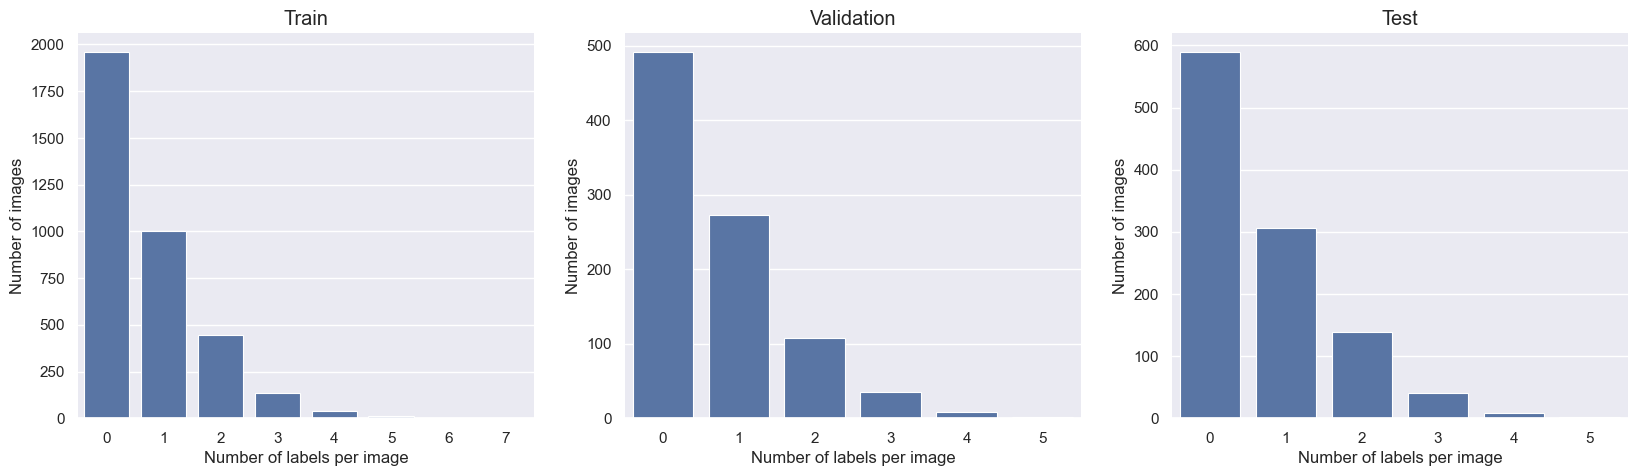

In [6]:
### OUR CODE ###
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.set(style="darkgrid")
sns.set_palette("Set2")
sns.set_context("paper", font_scale=1.5)
sns.despine(left=True)
sns.countplot(x=train_df[class_columns].sum(axis=1), ax=ax[0])
ax[0].set_title("Train")
ax[0].set_xlabel("Number of labels per image")
ax[0].set_ylabel("Number of images")
sns.countplot(x=valid_df[class_columns].sum(axis=1), ax=ax[1])
ax[1].set_title("Validation")
ax[1].set_xlabel("Number of labels per image")
ax[1].set_ylabel("Number of images")
sns.countplot(x=test_df[class_columns].sum(axis=1), ax=ax[2])
ax[2].set_title("Test")
ax[2].set_xlabel("Number of labels per image")
ax[2].set_ylabel("Number of images")
plt.show()

check if the number of patients with each pathology is the same across the train, validation, and test sets.

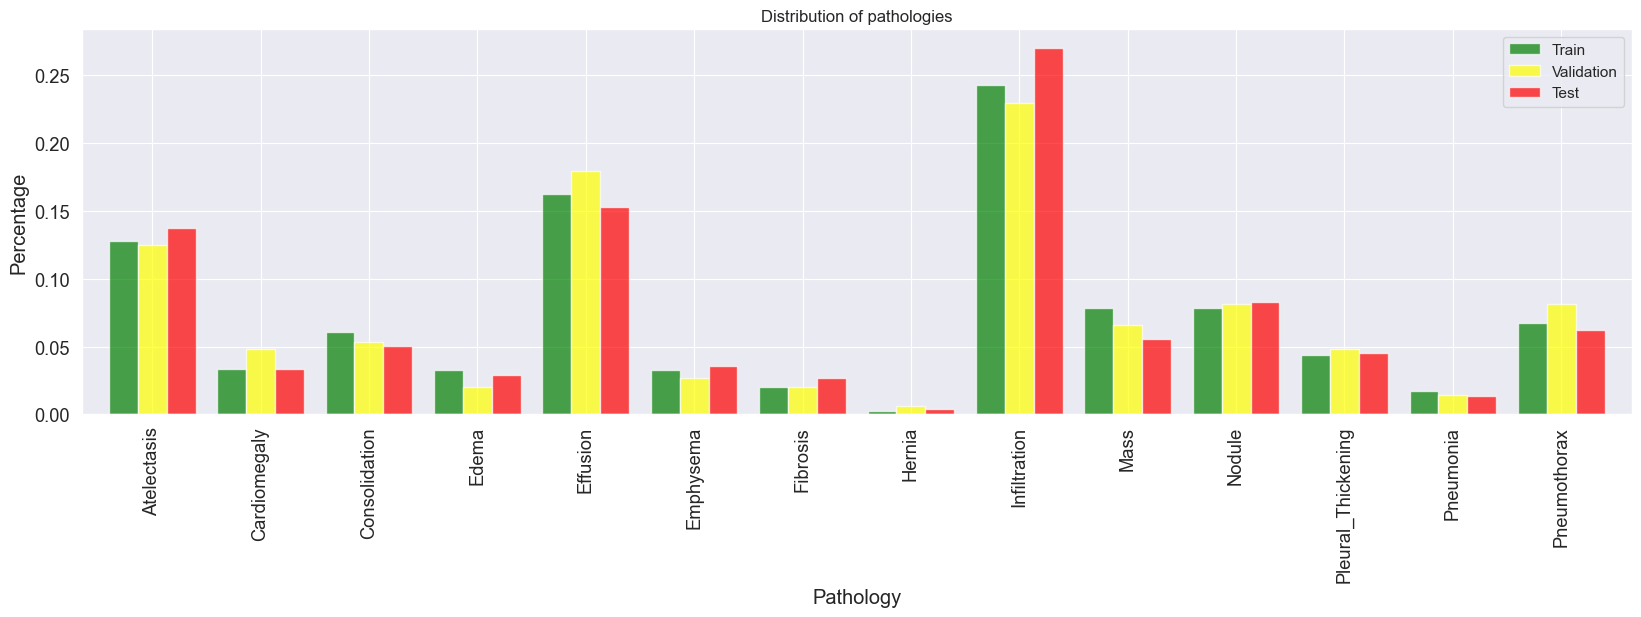

In [7]:
### OUR CODE ###
fig, ax = plt.subplots(figsize=(20, 5))
sns.set(style="darkgrid")
sns.set_palette(["green", "yellow", "red"])  # Set the desired colors

df_count_train = train_df[class_columns].sum(axis=0)
df_count_train = df_count_train / df_count_train.sum()

df_count_valid = valid_df[class_columns].sum(axis=0)
df_count_valid = df_count_valid / df_count_valid.sum()

df_count_test = test_df[class_columns].sum(axis=0)
df_count_test = df_count_test / df_count_test.sum()

# Combine the data into a single dataframe for plotting
df_combined = pd.DataFrame({'Train': df_count_train, 'Validation': df_count_valid, 'Test': df_count_test})

df_combined.plot(kind='bar', ax=ax, width=0.8, alpha=0.7)

ax.set_title("Distribution of pathologies")
ax.set_xlabel("Pathology")
ax.set_ylabel("Percentage")
ax.legend()
plt.show()


The decision of performing data balancing or not will be based on the performance of the model on the validation set. If the model is overfitting, and maybe taking decisions based on frequency, we will perform data balancing.

## Image Statistics

In [8]:
img_dir ='deliverable_images'
def get_pixel_values(sample_img):
    raw_image = plt.imread(os.path.join(img_dir, sample_img))
    return raw_image.flatten()

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3601 entries, 0 to 5604
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Image Index         3601 non-null   object
 1   Patient ID          3601 non-null   int64 
 2   Atelectasis         3601 non-null   int64 
 3   Cardiomegaly        3601 non-null   int64 
 4   Consolidation       3601 non-null   int64 
 5   Edema               3601 non-null   int64 
 6   Effusion            3601 non-null   int64 
 7   Emphysema           3601 non-null   int64 
 8   Fibrosis            3601 non-null   int64 
 9   Hernia              3601 non-null   int64 
 10  Infiltration        3601 non-null   int64 
 11  Mass                3601 non-null   int64 
 12  Nodule              3601 non-null   int64 
 13  Pleural_Thickening  3601 non-null   int64 
 14  Pneumonia           3601 non-null   int64 
 15  Pneumothorax        3601 non-null   int64 
dtypes: int64(15), object(1)
memor

In [10]:
# takes my computer about 10 minutes to run
### OUR CODE ###
import warnings
warnings.filterwarnings("ignore")

print("Getting pixel values for train set...")
train_df['Image Pixel Value'] = train_df['Image Index'].apply(get_pixel_values)
train_df['Image Pixel'] = train_df['Image Pixel Value'].apply(lambda x: x.reshape(np.sqrt(len(x)).astype(np.int64), np.sqrt(len(x)).astype(np.int64)))
print("Getting pixel values for validation set...")
valid_df['Image Pixel Value'] = valid_df['Image Index'].apply(get_pixel_values)
valid_df['Image Pixel'] = valid_df['Image Pixel Value'].apply(lambda x: x.reshape(np.sqrt(len(x)).astype(np.int64), np.sqrt(len(x)).astype(np.int64)))
print("Getting pixel values for test set...")
test_df['Image Pixel Value'] = test_df['Image Index'].apply(get_pixel_values)
test_df['Image Pixel'] = test_df['Image Pixel Value'].apply(lambda x: x.reshape(np.sqrt(len(x)).astype(np.int64), np.sqrt(len(x)).astype(np.int64)))

print("Computing statistics for train set...")
train_df['mean'] = train_df['Image Pixel Value'].apply(lambda x: x.mean())
train_df['std'] = train_df['Image Pixel Value'].apply(lambda x: x.std())

print("Computing statistics for validation set...")
valid_df['mean'] = valid_df['Image Pixel Value'].apply(lambda x: x.mean())
valid_df['std'] = valid_df['Image Pixel Value'].apply(lambda x: x.std())

print("Computing statistics for test set...")
test_df['mean'] = test_df['Image Pixel Value'].apply(lambda x: x.mean())
test_df['std'] = test_df['Image Pixel Value'].apply(lambda x: x.std())



Getting pixel values for train set...
Getting pixel values for validation set...
Getting pixel values for test set...
Computing statistics for train set...
Computing statistics for validation set...
Computing statistics for test set...


In [ ]:
# strange_images = ['00011041_000.png',

The dimensions of the image are 1024 pixels width and 1024 pixels height, one single color channel
The maximum pixel value is 1.0000 and the minimum is 0.0000
The mean value of the pixels is 0.5054 and the standard deviation is 0.2701


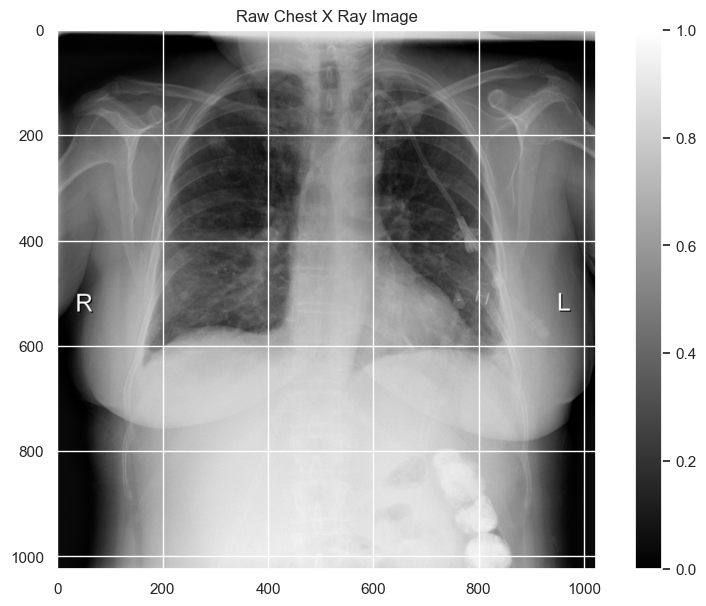

In [11]:
# Get the first image that was listed in the train_df dataframe
sample = train_df.sample(1)
image_id = sample['Image Index'].item()
raw_image = plt.imread(os.path.join(img_dir, image_id))
plt.imshow(raw_image, cmap='gray')
plt.grid(color='w', linestyle='-', linewidth=1)
plt.colorbar()
plt.title('Raw Chest X Ray Image')
print(f"The dimensions of the image are {raw_image.shape[0]} pixels width and {raw_image.shape[1]} pixels height, one single color channel")
print(f"The maximum pixel value is {raw_image.max():.4f} and the minimum is {raw_image.min():.4f}")
print(f"The mean value of the pixels is {raw_image.mean():.4f} and the standard deviation is {raw_image.std():.4f}")

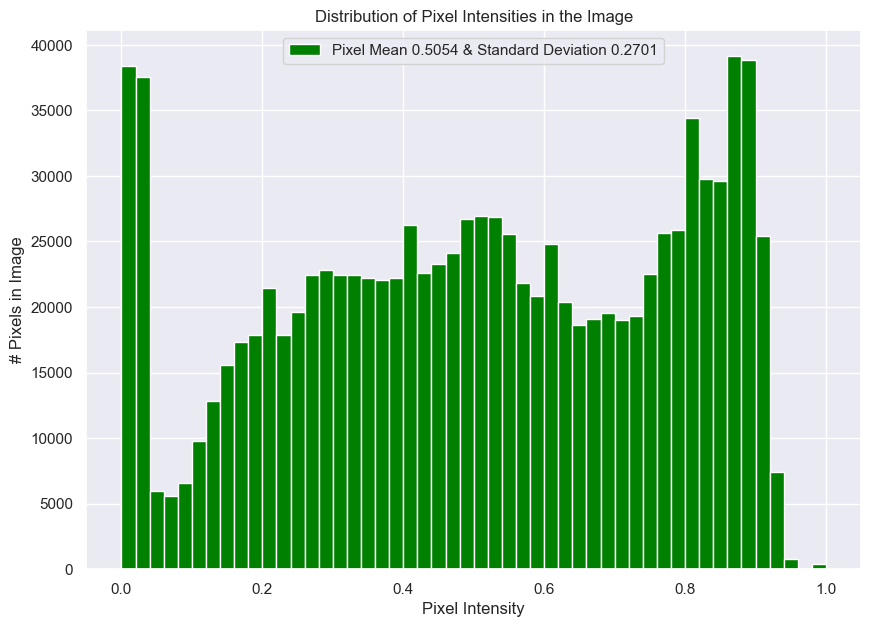

In [12]:
raw_image = sample['Image Pixel Value'].values[0]
mean = sample['mean'].values[0]
std = sample['std'].values[0]
plt.hist(raw_image, bins=50, label=f'Pixel Mean {mean:.4f} & Standard Deviation {std:.4f}')
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')
plt.show()

### Pixel Value Distribution by Class:

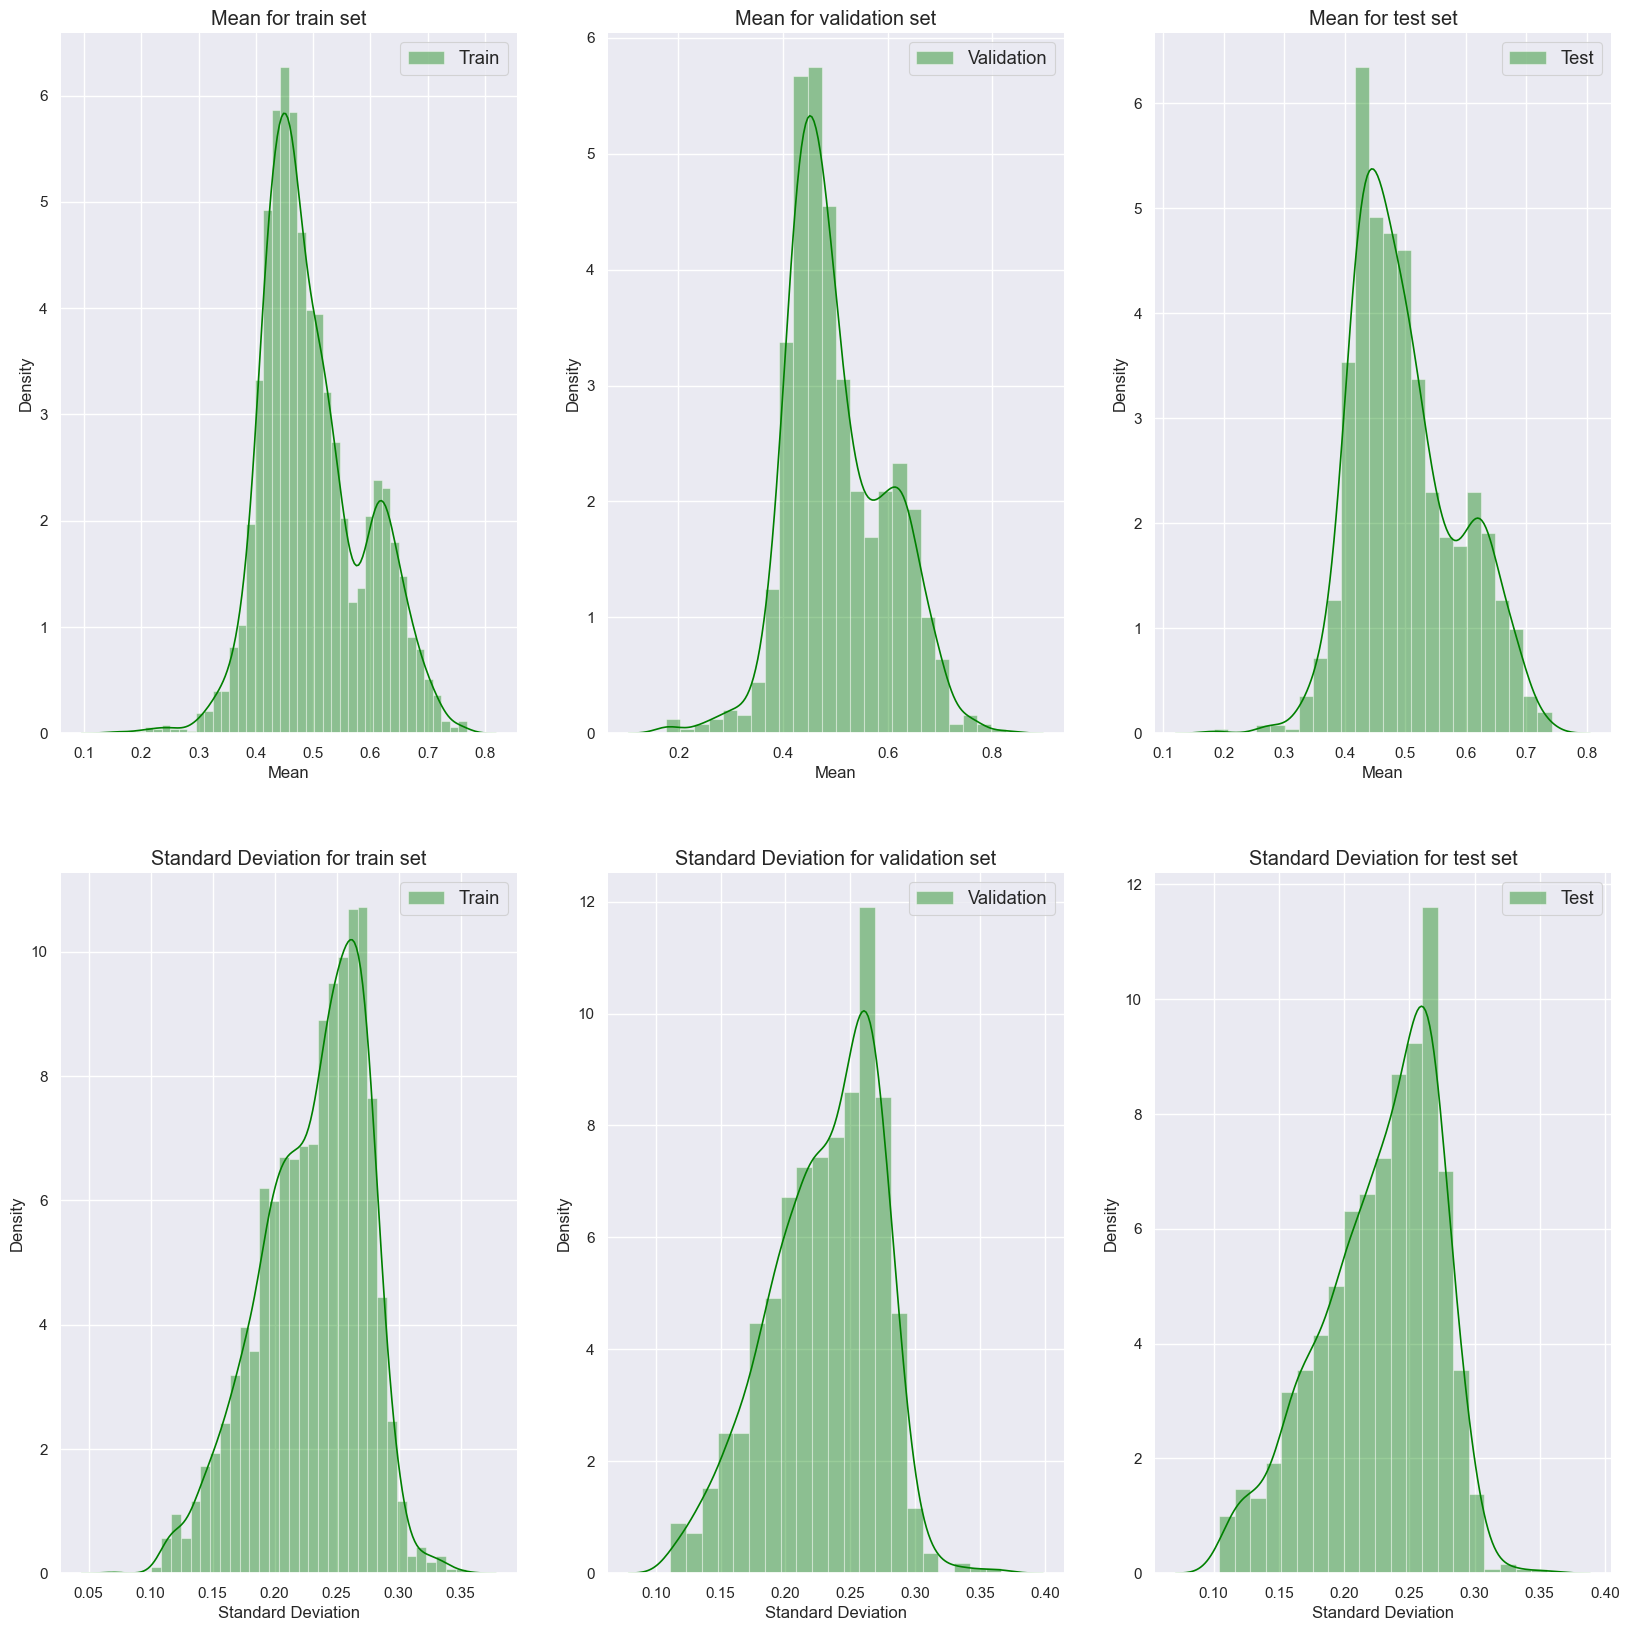

In [13]:
# plot the all the means and standard deviations of all the images of the train test and validation sets in 6 subplots
### OUR CODE ###
fig, ax = plt.subplots(2, 3, figsize=(20, 20))
sns.set(style="darkgrid")
sns.set_palette("Set2")
sns.set_context("paper", font_scale=1.5)
sns.despine(left=True)
sns.distplot(train_df['mean'], ax=ax[0, 0], label='Train')
ax[0, 0].set_title("Mean for train set")
ax[0, 0].set_xlabel("Mean")
ax[0, 0].set_ylabel("Density")
ax[0, 0].legend()
sns.distplot(valid_df['mean'], ax=ax[0, 1], label='Validation')
ax[0, 1].set_title("Mean for validation set")
ax[0, 1].set_xlabel("Mean")
ax[0, 1].set_ylabel("Density")
ax[0, 1].legend()
sns.distplot(test_df['mean'], ax=ax[0, 2], label='Test')
ax[0, 2].set_title("Mean for test set")
ax[0, 2].set_xlabel("Mean")
ax[0, 2].set_ylabel("Density")
ax[0, 2].legend()
sns.distplot(train_df['std'], ax=ax[1, 0], label='Train')
ax[1, 0].set_title("Standard Deviation for train set")
ax[1, 0].set_xlabel("Standard Deviation")
ax[1, 0].set_ylabel("Density")
ax[1, 0].legend()
sns.distplot(valid_df['std'], ax=ax[1, 1], label='Validation')
ax[1, 1].set_title("Standard Deviation for validation set")
ax[1, 1].set_xlabel("Standard Deviation")
ax[1, 1].set_ylabel("Density")
ax[1, 1].legend()
sns.distplot(test_df['std'], ax=ax[1, 2], label='Test')
ax[1, 2].set_title("Standard Deviation for test set")
ax[1, 2].set_xlabel("Standard Deviation")
ax[1, 2].set_ylabel("Density")
ax[1, 2].legend()
plt.show()

Text(0, 0.5, 'Standard Deviation')

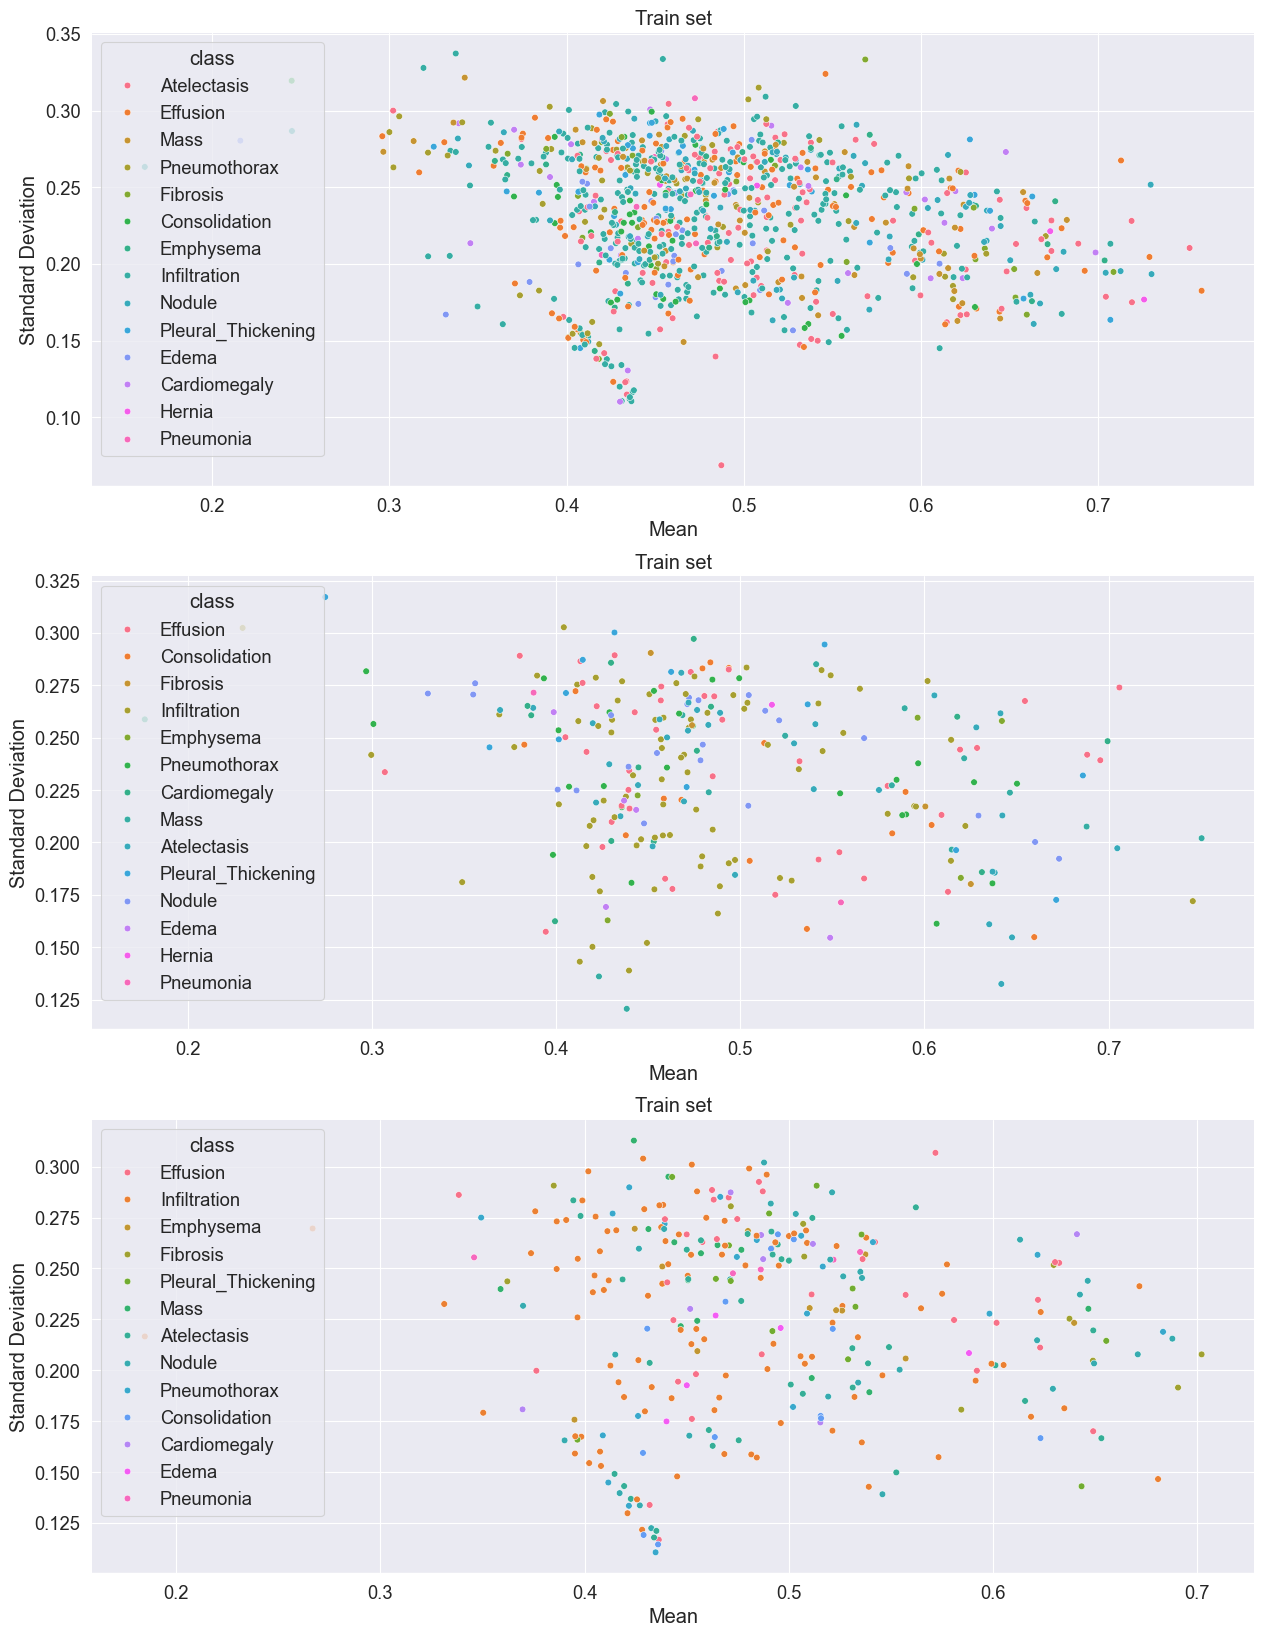

In [14]:
# do a scatter plot of the mean vs standard deviation with different colors for each class the sample belong to. If the a sample has multiple 
# labels, then it will be plotted multiple times. Do it for the train test and validation sets on 3 different plots 
### OUR CODE ###
def has_unique_diagnosis(row):
    return row[class_columns].sum() == 1

fig, ax = plt.subplots(3, 1, figsize=(15, 20))
sns.set(style="darkgrid")
sns.set_palette("Set2")
sns.set_context("paper", font_scale=1.5)
sns.despine(left=True)
train_df_unique = train_df[train_df.apply(has_unique_diagnosis, axis=1)]
train_df_unique['class'] = train_df_unique[class_columns].idxmax(axis=1)
sns.scatterplot(x='mean', y='std', hue='class', data=train_df_unique, ax=ax[0])
ax[0].set_title("Train set")
ax[0].set_xlabel("Mean")
ax[0].set_ylabel("Standard Deviation")

sns.set(style="darkgrid")
sns.set_palette("Set2")
sns.set_context("paper", font_scale=1.5)
sns.despine(left=True)
valid_df_unique = valid_df[valid_df.apply(has_unique_diagnosis, axis=1)]
valid_df_unique['class'] = valid_df_unique[class_columns].idxmax(axis=1)
sns.scatterplot(x='mean', y='std', hue='class', data=valid_df_unique, ax=ax[1])
ax[1].set_title("Train set")
ax[1].set_xlabel("Mean")
ax[1].set_ylabel("Standard Deviation")

sns.set(style="darkgrid")
sns.set_palette("Set2")
sns.set_context("paper", font_scale=1.5)
sns.despine(left=True)
test_df_unique = test_df[test_df.apply(has_unique_diagnosis, axis=1)]
test_df_unique['class'] = test_df_unique[class_columns].idxmax(axis=1)
sns.scatterplot(x='mean', y='std', hue='class', data=test_df_unique, ax=ax[2])
ax[2].set_title("Train set")
ax[2].set_xlabel("Mean")
ax[2].set_ylabel("Standard Deviation")

We see no specific distribution when it comes to intensities

### Spatial Statistics:

In [15]:
### OUR CODE ###
import cv2
from skimage.feature import graycomatrix
from skimage import io
import numpy as np

# Read an example grayscale X-ray image (replace 'your_image_path' with the actual path)
image = sample['Image Pixel'].values[0]

# Convert the image to uint8 format if needed
image = (image * 255).astype(np.uint8)

# Define the distance and angle parameters for GLCM
distance = 1
angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]

# Calculate GLCM
glcm = graycomatrix(image, distances=[distance], angles=angles, symmetric=True, normed=True)

# Extract contrast and correlation features from GLCM
contrast = glcm[0, 0, :, :].sum()
correlation = np.sum(glcm[0, 0, :, :] * np.outer(np.arange(glcm.shape[2]), np.arange(glcm.shape[3])))

print(f"Contrast: {contrast}")
print(f"Correlation: {correlation}")


Contrast: 0.040561475833146995
Correlation: 0.0


**Contrast**: The contrast value is a measure of the local variations in pixel intensity. In this case, the value of 0.0191 suggests relatively low contrast, indicating that adjacent pixels in the image have similar intensities.

**Correlation**: The correlation value is a measure of the linear dependence between pixel intensities at different locations. A correlation of 0.0 indicates a lack of linear correlation, suggesting that there is no strong linear relationship between pixel values at different positions in the image.

In [106]:
### OUR CODE ###
from skimage import feature

# Read the grayscale X-ray image (replace 'your_image_path' with the actual path)
image = sample['Image Pixel'].values[0]
# Convert the image to uint8 format if needed
image = (image * 255).astype(np.uint8)

# Compute LBP
radius = 1
n_points = 8 * radius
lbp = feature.local_binary_pattern(image, n_points, radius, method='uniform')

# Extract histogram from LBP
hist, _ = np.histogram(lbp, bins=np.arange(0, n_points + 3), range=(0, n_points + 2))

print("LBP Histogram:")
print(hist)


LBP Histogram:
[ 51040  68955  44012  88141 122097 141681  76460  83176 226774 146240]


The LBP histogram provides information about the distribution of local binary patterns in the image. Each bin in the histogram corresponds to a unique pattern, and the values in the histogram indicate the frequency of occurrence for each pattern.

The highest frequency occurs in the bin corresponding to a pattern index of 8 (bin index 9), suggesting that local patterns with 8 transitions between 0 and 1 (uniform pattern) are prevalent in the image.

The histogram values in other bins indicate the frequencies of other LBP patterns present in the image.

# Image Preprocessing in Keras

### Standardization

Normalizing images is better suited for training a convolutional neural network. For this task we use the Keras [ImageDataGenerator](https://keras.io/preprocessing/image/) function to perform data preprocessing and data augmentation.
The `image_generator` will adjust the image data such that the new mean of the data will be zero, and the standard deviation of the data will be 1.  

In other words, the generator will replace each pixel value in the image with a new value calculated by subtracting the mean and dividing by the standard deviation.

$$\frac{x_i - \mu}{\sigma}$$

Create an image generator for preprocessing. Pre-process the data using the `image_generator`as well as reduce the image size down to 320x320 pixels.

In [16]:
# Import data generator from keras https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator

In [17]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for training set, normalizing using batch
    statistics.

    Args:
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        train_generator (DataFrameIterator): iterator over training set
    """        
    print("getting train generator...") 
    # Normalize images  --- Generate batches of tensor image data with real-time data augmentation
    image_generator = ImageDataGenerator(
        samplewise_center=True,              #Set each sample mean to 0
        samplewise_std_normalization= True)  # Divide each input by its standard deviation
    
    # flow from directory with specified batch size and target image size
    # flow_from_dataframe ==> https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
    # RETURNS a DataFrameIterator yielding tuples of (x, y) where x is a numpy array containing a batch of images with 
    # shape (batch_size, *target_size, channels) and y is a numpy array of corresponding labels
    # default data format of ImageGenerator is channels_last
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",       #  Mode for yielding the targets, one of "binary", "categorical", "input", "multi_output", "raw", sparse" or None. Default: "categorical".
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

In [18]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, 
                                 seed=1, target_w = 320, target_h = 320):
    """
    Return generator for validation set and test test set using 
    normalization statistics from training set.

    Args:
      valid_df (dataframe): dataframe specifying validation data.
      test_df (dataframe): dataframe specifying test data.
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        test_generator (DataFrameIterator) and valid_generator: iterators over test set and validation set respectively
    """
    # get generator to sample dataset
    print(f"\nextracting {sample_size} train images to normalize validation and test datasets...")

    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=image_dir, 
        x_col="Image Index", 
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample
    batch = raw_train_generator.next() # generate a batch of samples and associated labels 
    data_sample = batch[0]             # => we need only the sample imgs ie batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data - we use this generator normalizing mean and std using the train sample of 100
    image_generator.fit(data_sample)
    
    print("\ngetting valid generator...")

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    
    print("\ngetting test generator...")
    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

In [19]:
labels = ['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Atelectasis',
              'Pneumothorax', 'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation']
IMAGE_DIR = "deliverable_images/"
train_generator = get_train_generator(train_df, IMAGE_DIR, "Image Index", labels)
valid_generator, test_generator= get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, "Image Index", labels)

getting train generator...


Found 3601 validated image filenames.

extracting 100 train images to normalize validation and test datasets...
Found 3601 validated image filenames.

getting valid generator...
Found 919 validated image filenames.

getting test generator...
Found 1086 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The dimensions of the image are 320 pixels width and 320 pixels height
The maximum pixel value is 3.2693 and the minimum is -2.8553
The mean value of the pixels is -0.0000 and the standard deviation is 1.0000


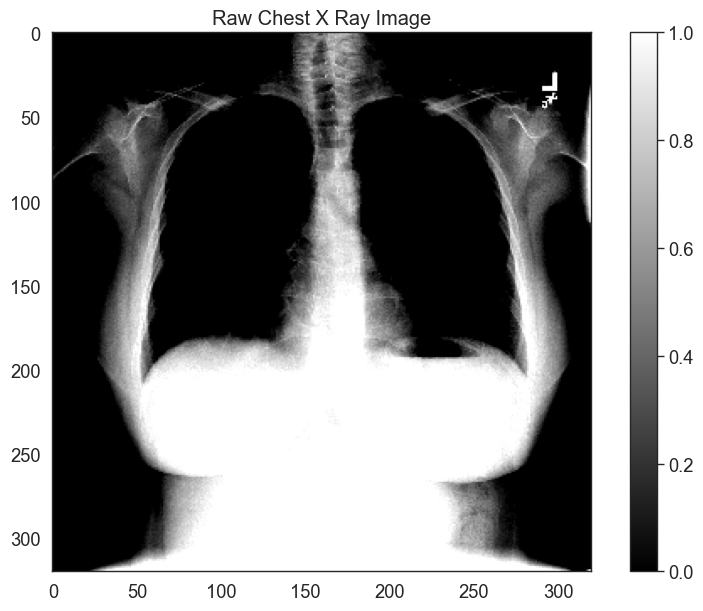

In [20]:
# Plot a processed image
sns.set_style("white")
generated_image, label = train_generator.__getitem__(0)
plt.imshow(generated_image[0], cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')
print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[2]} pixels height")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
print(f"The mean value of the pixels is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}")

In [21]:
print(generated_image.shape, generated_image[0].shape)
print(raw_image.shape)

(8, 320, 320, 3) (320, 320, 3)
(1048576,)


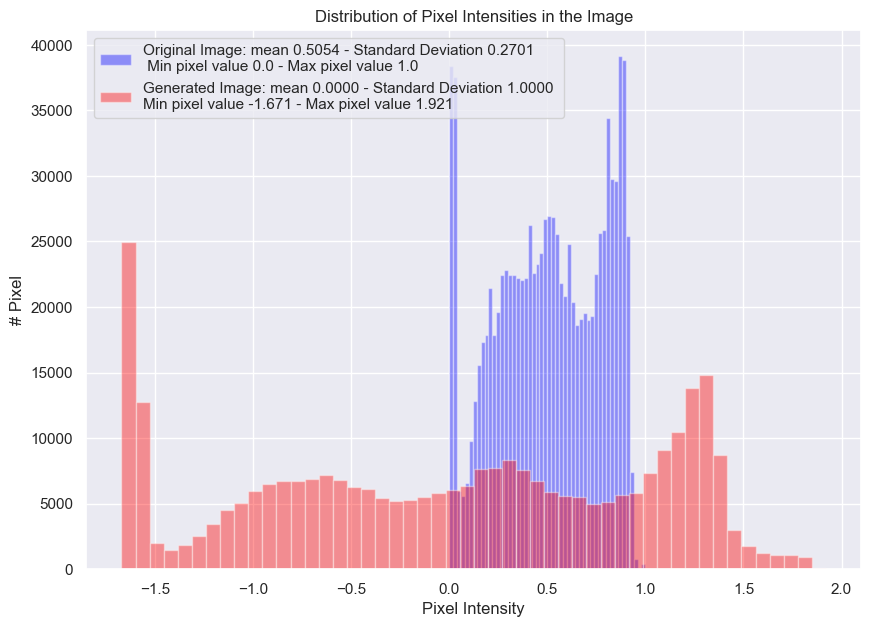

In [22]:
# Include a histogram of the distribution of the pixels
sns.set()
plt.figure(figsize=(10, 7))

# Plot histogram for original iamge
sns.distplot(raw_image.ravel(), 
             label=f'Original Image: mean {np.mean(raw_image):.4f} - Standard Deviation {np.std(raw_image):.4f} \n '
             f'Min pixel value {np.min(raw_image):.4} - Max pixel value {np.max(raw_image):.4}',
             color='blue', 
             kde=False)

# Plot histogram for generated image
sns.distplot(generated_image[0].ravel(), 
             label=f'Generated Image: mean {np.mean(generated_image[0]):.4f} - Standard Deviation {np.std(generated_image[0]):.4f} \n'
             f'Min pixel value {np.min(generated_image[0]):.4} - Max pixel value {np.max(generated_image[0]):.4}', 
             color='red', 
             kde=False)

# Place legends
plt.legend()
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixel')
plt.show()

### Addressing Class Imbalance - Weighted Loss
One of the challenges with working with medical diagnostic datasets is the large class imbalance present in such datasets, as we saw in the EDA plots.

We can see from this plot that the prevalance of positive cases varies significantly across the different pathologies. (These trends mirror the ones in the full dataset as well.) 
* The `Hernia` pathology has the greatest imbalance with the proportion of positive training cases being about 0.2%. 
* But even the `Infiltration` pathology, which has the least amount of imbalance, has only 17.5% of the training cases labelled positive.

Ideally, we would train our model using an evenly balanced dataset so that the positive and negative training cases would contribute equally to the loss. 

#### Impact of class imbalance on loss function

Let's take a closer look at this. Assume we would have used a normal cross-entropy loss for each pathology. We recall that the cross-entropy loss contribution from the $i^{th}$ training data case is:

$$\mathcal{L}_{cross-entropy}(x_i) = -(y_i \log(f(x_i)) + (1-y_i) \log(1-f(x_i))),$$

where $x_i$ and $y_i$ are the input features and the label, and $f(x_i)$ is the output of the model, i.e. the probability that it is positive. 

Note that for any training case, either $y_i=0$ or else $(1-y_i)=0$, so only one of these terms contributes to the loss (the other term is multiplied by zero, and becomes zero). 

We can rewrite the overall average cross-entropy loss over the entire training set $\mathcal{D}$ of size $N$ as follows: 

$$\mathcal{L}_{cross-entropy}(\mathcal{D}) = - \frac{1}{N}\big( \sum_{\text{positive examples}} \log (f(x_i)) + \sum_{\text{negative examples}} \log(1-f(x_i)) \big).$$

Using this formulation, we can see that if there is a large imbalance with very few positive training cases, for example, then the loss will be dominated by the negative class. Summing the contribution over all the training cases for each class (i.e. pathological condition), we see that the contribution of each class (i.e. positive or negative) is: 

$$freq_{p} = \frac{\text{number of positive examples}}{N} $$

$$\text{and}$$

$$freq_{n} = \frac{\text{number of negative examples}}{N}.$$

### Computing Class Frequencies

In [23]:
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # total number of patients (rows)
    N = labels.shape[0]
    
    positive_frequencies = np.sum(labels, axis=0)/N
    negative_frequencies = (N - np.sum(labels, axis=0))/N  # broadcasting of N to a line vector of dim num_classes

    ### END CODE HERE ###
    return positive_frequencies, negative_frequencies

In [24]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos

array([0.02360455, 0.02304915, 0.11496806, 0.0016662 , 0.17134129,
       0.05554013, 0.05526243, 0.09025271, 0.04776451, 0.03082477,
       0.01194113, 0.01416273, 0.02304915, 0.0427659 ])

In [25]:
freq_neg

array([0.97639545, 0.97695085, 0.88503194, 0.9983338 , 0.82865871,
       0.94445987, 0.94473757, 0.90974729, 0.95223549, 0.96917523,
       0.98805887, 0.98583727, 0.97695085, 0.9572341 ])

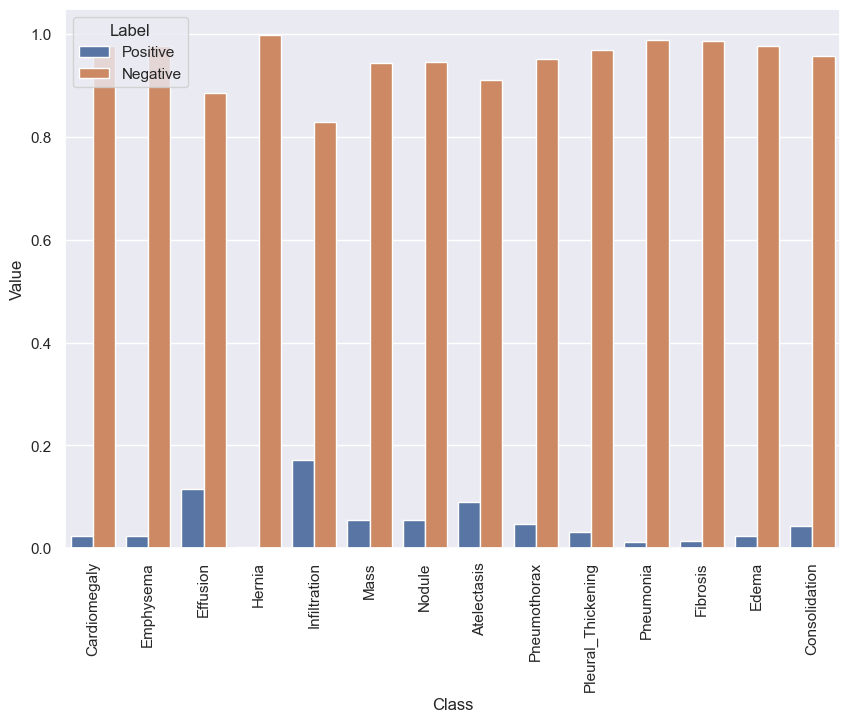

In [26]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
# data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True) gives an error. solve it
data_neg = pd.DataFrame([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)])
#combine both dataframes with pandas concat
data = pd.concat([data, data_neg], ignore_index=True)

plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

The contributions of positive cases is significantly lower than that of the negative ones. However, we want the contributions to be equal. One way of doing this is by multiplying each example from each class by a class-specific weight factor, $w_{pos}$ and $w_{neg}$, so that the overall contribution of each class is the same. 

To have this, we want 

$$w_{pos} \times freq_{p} = w_{neg} \times freq_{n},$$

which we can do simply by taking 

$$w_{pos} = freq_{neg}$$
$$w_{neg} = freq_{pos}$$

This way, we will be balancing the contribution of positive and negative labels.

In [27]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

Let's verify this by graphing the two contributions next to each other :

<Axes: xlabel='Class', ylabel='Value'>

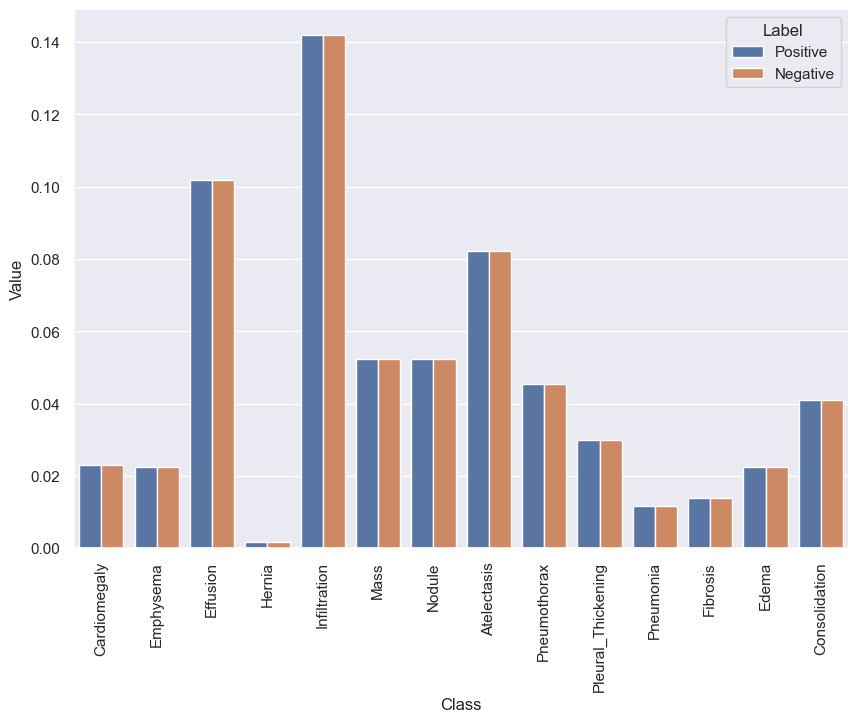

In [28]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data_neg = pd.DataFrame([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)])

data = pd.concat([data, data_neg], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

After computing the weights, our final weighted loss for each training case will be 

$$\mathcal{L}_{cross-entropy}^{w}(x) = - (w_{p} y \log(f(x)) + w_{n}(1-y) \log( 1 - f(x) ) ).$$

### Weighted Loss

In [29]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (Float): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0
        
        ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

        for i in range(len(pos_weights)):
            #covert pos_weights and neg_weights to float 32
            
            # for each class, add average weighted loss for that class 

            y_true=K.cast(y_true, dtype='float32')
   
            loss += - pos_weights[i] * K.mean(y_true[:,i] * K.log(y_pred[:,i] + epsilon)) \
            - neg_weights[i] * K.mean((1-y_true[:,i]) * K.log(1-y_pred[:,i] + epsilon)) #complete this line
        return loss
    
        ### END CODE HERE ###
    return weighted_loss             # this is a function taking 2 arguments y_true and y_pred

In [30]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3601 entries, 0 to 5604
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Image Index         3601 non-null   object 
 1   Patient ID          3601 non-null   int64  
 2   Atelectasis         3601 non-null   int64  
 3   Cardiomegaly        3601 non-null   int64  
 4   Consolidation       3601 non-null   int64  
 5   Edema               3601 non-null   int64  
 6   Effusion            3601 non-null   int64  
 7   Emphysema           3601 non-null   int64  
 8   Fibrosis            3601 non-null   int64  
 9   Hernia              3601 non-null   int64  
 10  Infiltration        3601 non-null   int64  
 11  Mass                3601 non-null   int64  
 12  Nodule              3601 non-null   int64  
 13  Pleural_Thickening  3601 non-null   int64  
 14  Pneumonia           3601 non-null   int64  
 15  Pneumothorax        3601 non-null   int64  
 16  Image Pixel

# DenseNet121
Use a pre-trained [DenseNet121](https://www.kaggle.com/pytorch/densenet121) model.Densenet is a convolutional network where each layer is connected to all other layers that are deeper in the network
- The first layer is connected to the 2nd, 3rd, 4th etc.
- The second layer is connected to the 3rd, 4th, 5th etc.
- For a detailed explanation of Densenet, check out the source of the image above, a paper by Gao Huang et al. 2018 called [Densely Connected Convolutional Networks](https://arxiv.org/pdf/1608.06993.pdf).
<img src="densenet.png" alt="U-net Image" width="400" align="middle"/>

## Model Architecture

we can load directly from Keras and then add two layers on top of it:
1. A `GlobalAveragePooling2D` layer to get the average of the last convolution layers from DenseNet121.
2. A `Dense` layer with `sigmoid` activation to get the prediction logits for each of our classes.

In [33]:
import keras
from keras.applications.densenet import DenseNet121
from keras.models import Model
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping, TensorBoard
from keras.preprocessing import image

def load_C3M3_model():
   
    class_pos = train_df.loc[:, labels].sum(axis=0)
    class_neg = len(train_df) - class_pos
    class_total = class_pos + class_neg
    #conever to float32

    pos_weights = class_pos / class_total
    neg_weights = class_neg / class_total
    #covert form float64 to float 32

    print("Got loss weights")
    # create the base pre-trained model
    base_model = DenseNet121(weights='densenet.hdf5', include_top=False)
    print("Loaded DenseNet")
    # add a global spatial average pooling layer
    x = base_model.output

    x = GlobalAveragePooling2D()(x)
    
    # and a logistic layer
    predictions = Dense(len(labels), activation="sigmoid")(x)

    print("Added layers")
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    model.compile(optimizer='adam', loss=get_weighted_loss(neg_weights, pos_weights))
    print("Compiled Model")
    # we load the weights in order to not have to train the whole model
    model.load_weights("pretrained_model.h5")
    print("Loaded Weights")
  
    return model

In [34]:
model = load_C3M3_model()

Got loss weights


Loaded DenseNet
Added layers

Compiled Model
Loaded Weights


let's see the layers that our model is composed of.

In [35]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, None, None, 3)        0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, None, None, 64)       9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, None, None, 64)       256       ['conv1/conv[0][0]']      

In [36]:
# Print out the total number of layers
layers_ = model.layers
print('total number of layers =',len(layers_))

total number of layers = 429


In [37]:
# The find() method returns an integer value:
# If substring doesn't exist inside the string, it returns -1, otherwise returns first occurence index
conv2D_layers = [layer for layer in model.layers 
                if str(type(layer)).find('Conv2D') > -1]

In [38]:
print('Model input -------------->', model.input)
print('Feature extractor output ->', model.get_layer('conv5_block16_concat').output)
print('Model output ------------->', model.output)

Model input --------------> KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Feature extractor output -> KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 1024), dtype=tf.float32, name=None), name='conv5_block16_concat/concat:0', description="created by layer 'conv5_block16_concat'")
Model output -------------> KerasTensor(type_spec=TensorSpec(shape=(None, 14), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")


## Training

In our case, we have already imported the weights. However, if we were to train from scratch, the provided code works and can be reused if we want more data or we want to try to freeze the weights of the pre-trained model by setting `trainable = False` before compiling and training the model.

In [39]:
#
#history=(model.fit(x=train_generator, 
#                              validation_data=valid_generator,
#                              steps_per_epoch=100, 
#                              validation_steps=25, 
#                              epochs = 1,verbose=1))
#
#plt.plot(history.history['loss'])
#plt.ylabel("loss")
#plt.xlabel("epoch")
#plt.title("Training Loss Curve")
#plt.show()

## Prediction and Evaluation
Now that we have a model, let's evaluate it using our test set. We can conveniently use the predict_generator function to generate the predictions for the images in our test set.

In [40]:
predicted_vals = model.predict(test_generator, steps = len(test_generator))
predicted_vals.shape  # number of test samples x number of classes to predict

136/136 [==============================] - 97s 678ms/step


(1086, 14)

### ROC Curve and AUROC
Compute metric called the AUC (Area Under the Curve) from the ROC ([Receiver Operating Characteristic](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)) curve. ideally we want a curve that is more to the left so that the top has more "area" under it, which indicates that the model is performing better.

In [41]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def get_roc_curve(labels, predicted_vals, generator):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = generator.labels[:, i]
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.savefig('ROC.png')
    plt.show()
    return auc_roc_vals

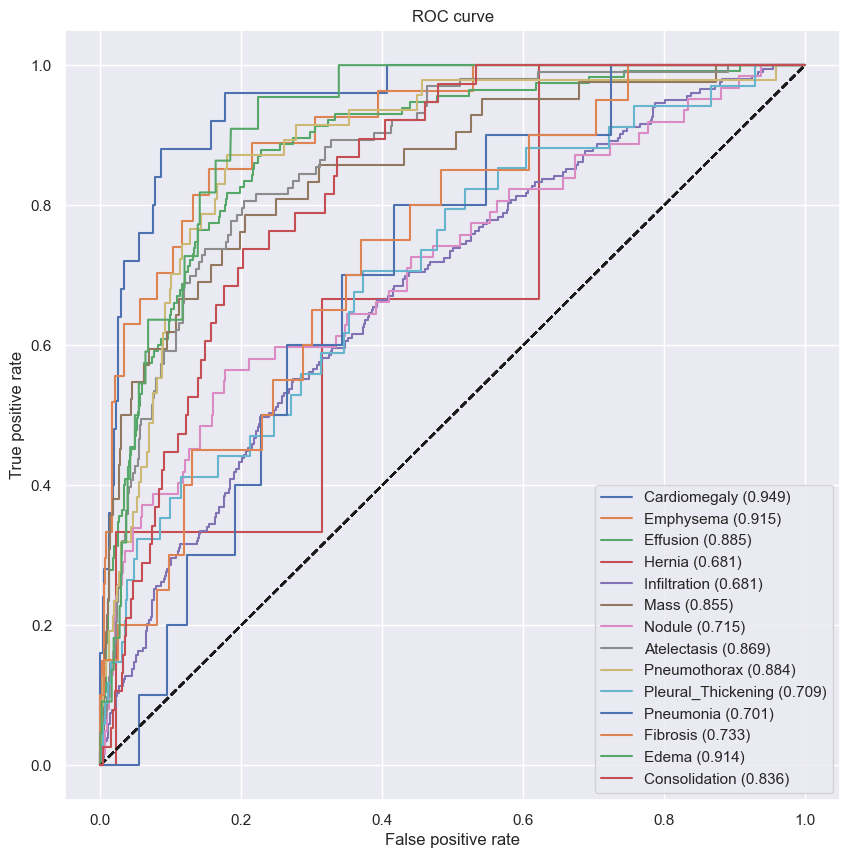

In [42]:
auc_rocs = get_roc_curve(labels, predicted_vals, test_generator)

In [43]:
print("areas under the curve : {} \n for all {} classes".format(auc_rocs,len(auc_rocs)))

areas under the curve : [0.9485391140433552, 0.9151190850907566, 0.8853893341691668, 0.680517082179132, 0.6808685125161089, 0.854930669585842, 0.7151272681451613, 0.8687295676994341, 0.8837056908238281, 0.7093491388951018, 0.7013011152416357, 0.7329268292682927, 0.9135979152426521, 0.8356267577340297] 
 for all 14 classes


Probability cutoff = 0.5

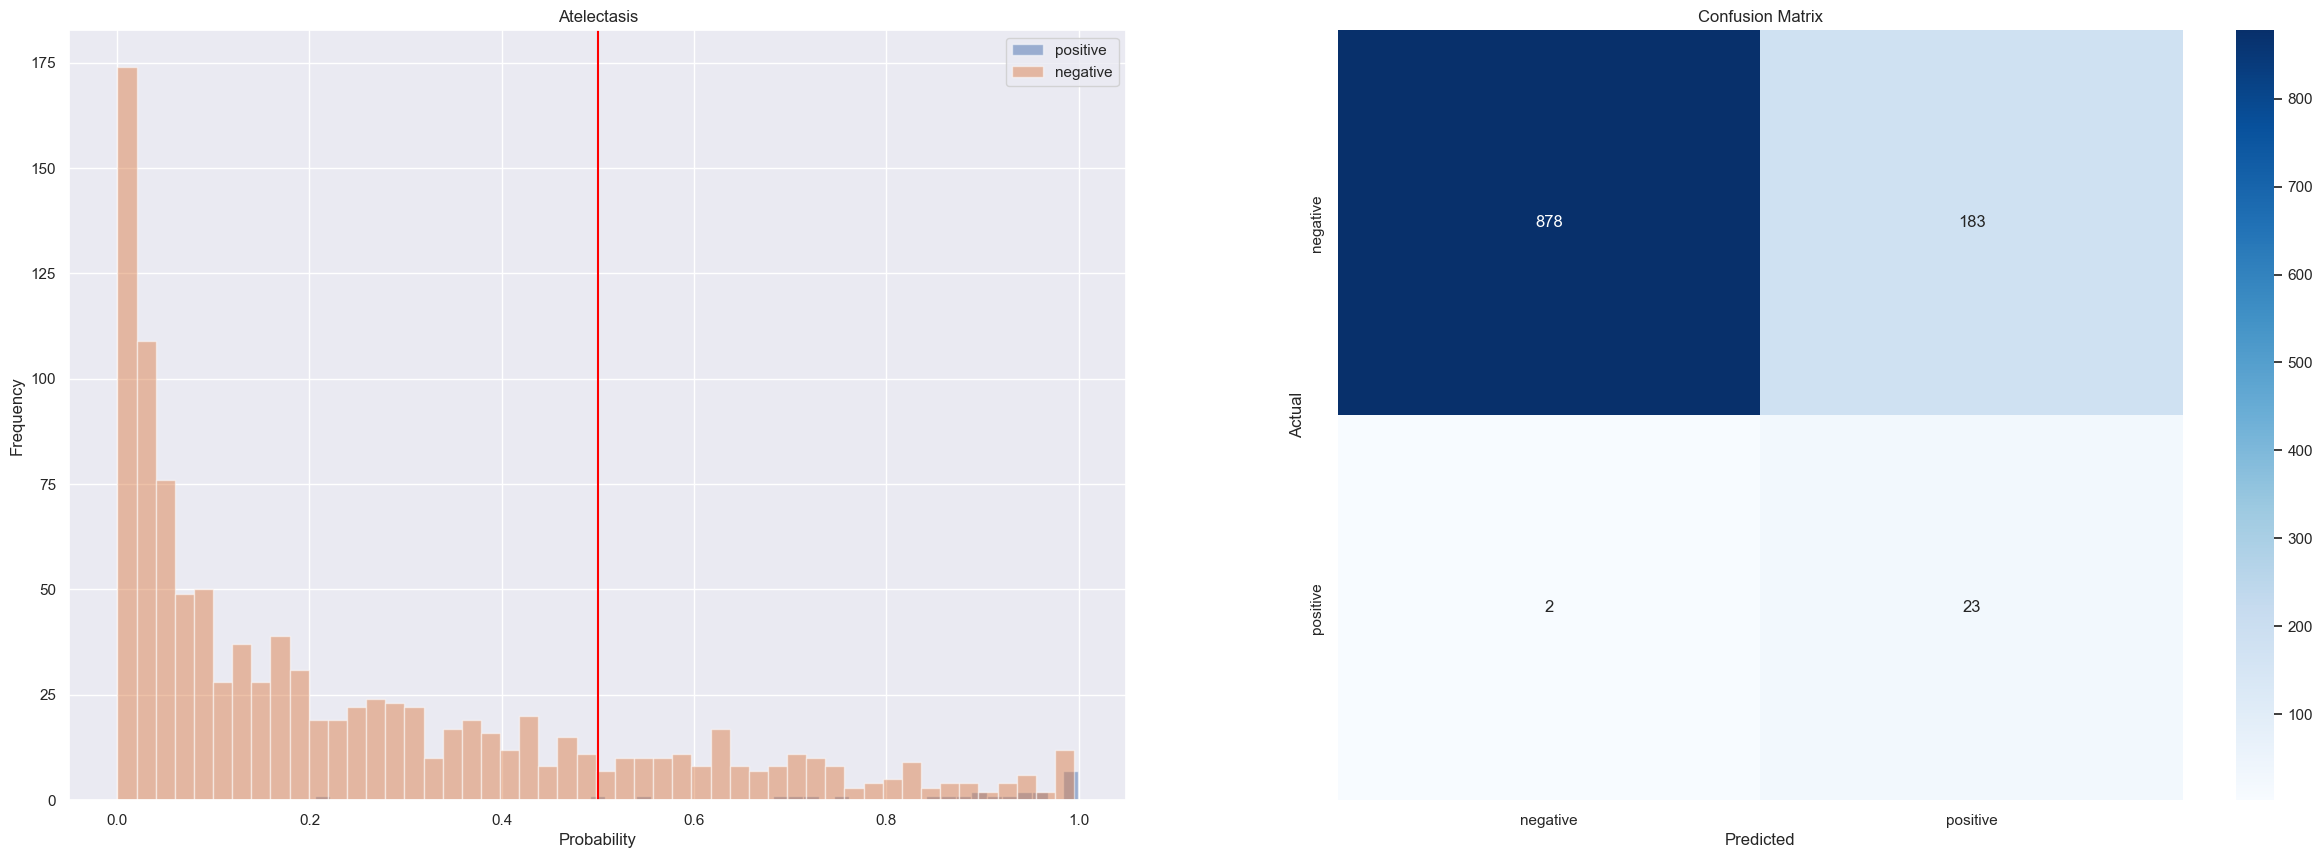

Recall: 92.0%
Precision: 11.16504854368932%


In [44]:
### OUR CODE ###
from sklearn.metrics import confusion_matrix

def plot_histogram(label, label_index, predicted_vals, mask, cutoff=0.5):
    # plot the overlaid histograms of predicted values for this label and the confusion matrix
    fig, ax = plt.subplots(1, 2, figsize=(30, 10))
    positive_indices = np.where(mask == 1)[0]
    negative_indices = np.where(mask == 0)[0]
    # set the number of bins to be plotted
    num_bins = 50
    ax[0].hist(predicted_vals[positive_indices, label_index], num_bins, alpha=0.5, label='positive')
    ax[0].hist(predicted_vals[negative_indices, label_index], num_bins, alpha=0.5, label='negative')
    ax[0].axvline(x=cutoff, color='red')
    ax[0].legend(loc='upper right')
    ax[0].set_title(label)
    ax[0].set_xlabel("Probability")
    ax[0].set_ylabel("Frequency")

    print("Probability cutoff = {}".format(cutoff))
    # print the confusion matrix under this probability cutoff
    cm = confusion_matrix(mask, predicted_vals[:, label_index] > cutoff)
    sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues)
    ax[1].set(xlabel='Predicted', ylabel='Actual')
    ax[1].set_title("Confusion Matrix")
    ax[1].xaxis.set_ticklabels(['negative', 'positive'])
    ax[1].yaxis.set_ticklabels(['negative', 'positive'])
    plt.show()
    
    print("Recall: {}%".format(100*cm[1,1]/(cm[1,0]+cm[1,1])))
    print("Precision: {}%".format(100*cm[1,1]/(cm[0,1]+cm[1,1])))

    # get best 3 and worst 3 predictions
    diff = np.abs(mask - predicted_vals[:, label_index])
    highest_indices = np.argsort(diff) # 3 smallest differences
    lowest_indices = highest_indices[::-1] # 3 largest differences
    return highest_indices[np.where(mask[highest_indices] == 1)][0:3],  lowest_indices[np.where(mask[lowest_indices] == 1)][0:3]


# needed_images = []
for label_index, label in enumerate(class_columns):
    mask = test_generator.labels[:, label_index]
    best_postives, worst_positives = plot_histogram(label, label_index, predicted_vals, mask)
    break
    # needed_images.extend(test_generator.filenames[i] for i in best_postives)
    # needed_images.extend(test_generator.filenames[i] for i in worst_positives)
    

## Interpreting Deep Learning Models

Let's load in an X-ray image.

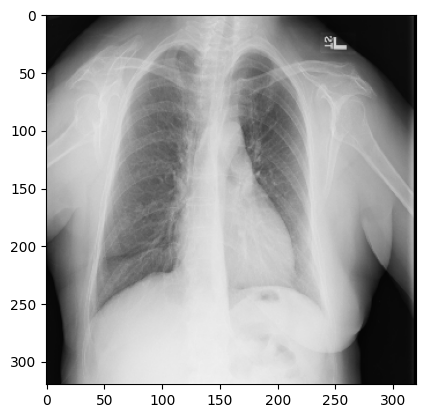

In [45]:
sns.reset_defaults()
from tensorflow.keras import preprocessing

def get_mean_std_per_batch(df, H=320, W=320):
    sample_data = []
    for idx, img in enumerate(df.sample(100)["Image Index"].values):
        path = IMAGE_DIR + img
        sample_data.append(np.array(image.load_img(path, target_size=(H, W))))

    mean = np.mean(sample_data[0])
    std = np.std(sample_data[0])
    return mean, std    

def load_image_normalize(path, mean, std, H=320, W=320):
    x = image.load_img(path, target_size=(H, W))
    x = preprocessing.image.img_to_array(x)
    x -= mean
    x /= std
    x = np.expand_dims(x, axis=0)
    return x

def load_image(path, df, preprocess=True, H = 320, W = 320):
    """Load and preprocess image."""
    x = image.load_img(path, target_size=(H, W))
    if preprocess:
        mean, std = get_mean_std_per_batch(df, H=H, W=W)
        x -= mean
        x /= std
        x = np.expand_dims(x, axis=0)
    return x

im_path = IMAGE_DIR + '00000682_001.png' 
x = load_image(im_path, train_df, preprocess=False)
plt.imshow(x, cmap = 'gray')
plt.show()

In [46]:
### OUR CODE ###
from tensorflow.keras import preprocessing
from tensorflow.keras import models

def grad_cam(model, img_tensor, class_index, layer_name, image_size):
    conv_layer = model.get_layer(layer_name)
    # KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 1024), dtype=tf.float32, name=None), name='conv5_block16_concat/concat:0', description="created by layer 'conv5_block16_concat'")
    heatmap_model = models.Model([model.inputs], [conv_layer.output, model.output])

    # Get gradient of the winner class w.r.t. the output of the (last) conv. layer
    with tf.GradientTape() as gtape:
        conv_output, predictions = heatmap_model(img_tensor)
        loss = predictions[:, class_index]
        grads = gtape.gradient(loss, conv_output)

    # Spatial Global Average Pooling
    pooled_grads = tf.reduce_mean(grads, axis=(1, 2), keepdims=True)

    # Multiply pooled gradients with the convolutional layer output
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_output), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat

    # Resize the heatmap to match the dimensions of the input image
    resized_heatmap = cv2.resize(heatmap[0], (image_size, image_size))

    # Normalize the resized heatmap
    resized_heatmap = np.maximum(resized_heatmap, 0)
    resized_heatmap /= np.max(resized_heatmap)

    return resized_heatmap


In [47]:
def compute_gradcam(model, img, mean, std, data_dir, df, 
                    labels, selected_labels, layer_name='conv5_block16_concat'):
    """
    Compute GradCAM for many specified labels for an image. 
    This method will use the `grad_cam` function.
    
    Args:
        model (Keras.model): Model to compute GradCAM for
        img (string): Image name we want to compute GradCAM for.
        mean (float): Mean to normalize to image.
        std (float): Standard deviation to normalize the image.
        data_dir (str): Path of the directory to load the images from.
        df(pd.Dataframe): Dataframe with the image features.
        labels ([str]): All output labels for the model.
        selected_labels ([str]): All output labels we want to compute the GradCAM for.
        layer_name: Intermediate layer from the model we want to compute the GradCAM for.
    """
    img_path = data_dir + img
    preprocessed_input = load_image_normalize(img_path, mean, std)
    predictions = model.predict(preprocessed_input)
    print(predictions)
    print("Ground Truth: ", ", ".join(np.take(labels, np.nonzero(df[df["Image Index"] == img][labels].values[0]))[0]))

    plt.figure(figsize=(20, 15))
    plt.subplot(151)
    plt.title("Original")
    plt.axis('off')
    plt.imshow(load_image(img_path, df, preprocess=False), cmap='gray')
    
    j = 1
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###    
    # Loop through all labels
    for i in range(len(labels)): # complete this line
        # Compute CAM and show plots for each selected label.
        
        # Check if the label is one of the selected labels
        if labels[i] in selected_labels: # complete this line
            
            # Use the grad_cam function to calculate gradcam
            gradcam = grad_cam(model, preprocessed_input, i, layer_name, image_size=320)
            
            ### END CODE HERE ###
            
            print("Generating gradcam for class %s (p=%2.2f)" % (labels[i], round(predictions[0][i], 3)))
            plt.subplot(151 + j)
            plt.title(labels[i] + ": " + str(round(predictions[0][i], 3)))
            plt.axis('off')
            plt.imshow(load_image(img_path, df, preprocess=False), cmap='gray')
            plt.imshow(gradcam, cmap='magma', alpha=min(0.5, predictions[0][i]))
            j +=1
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


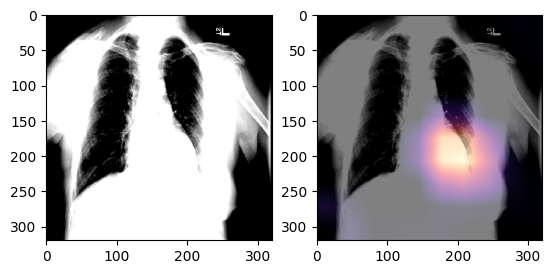

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


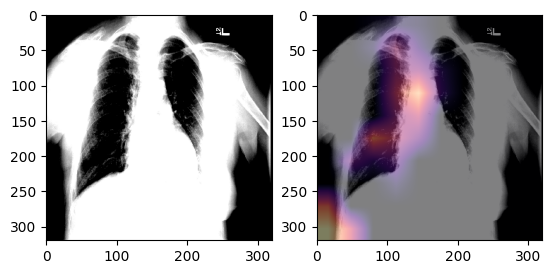

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


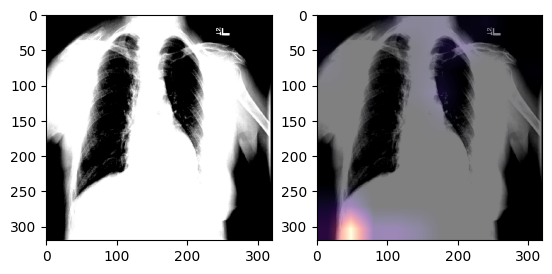

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


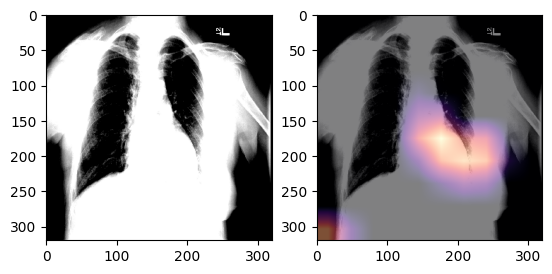

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


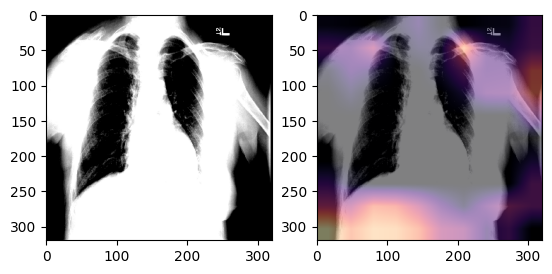

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


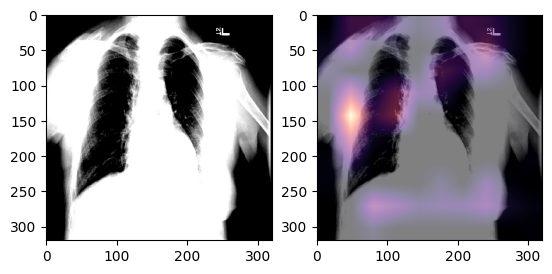

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


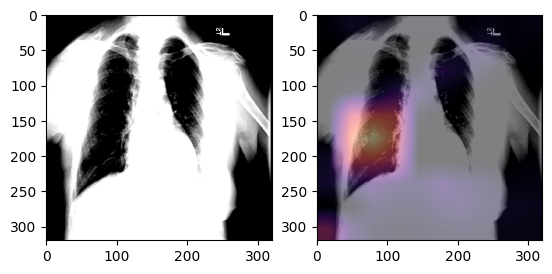

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


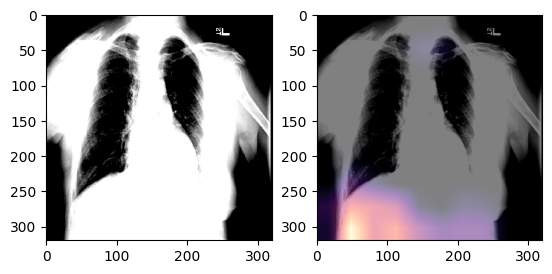

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


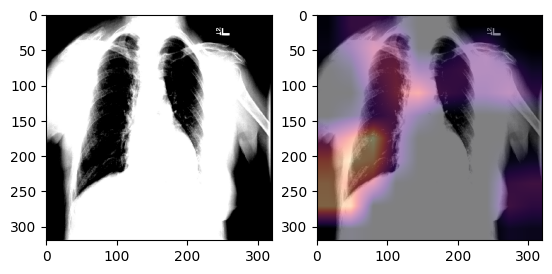

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


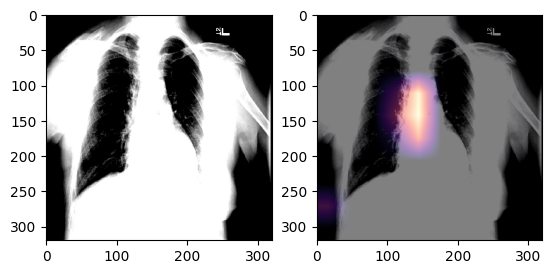

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


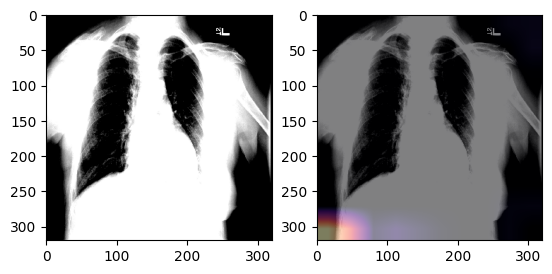

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


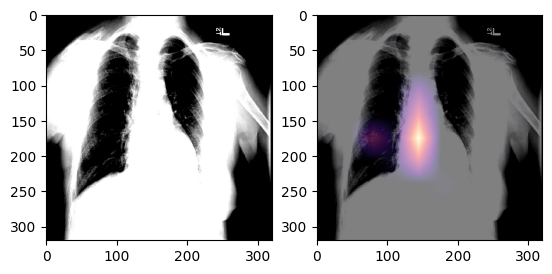

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


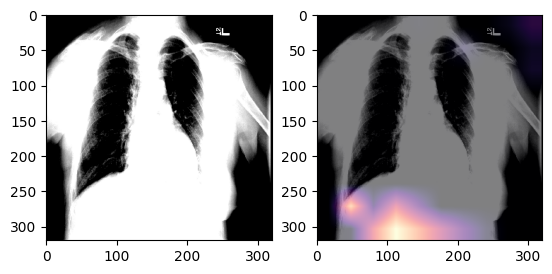

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


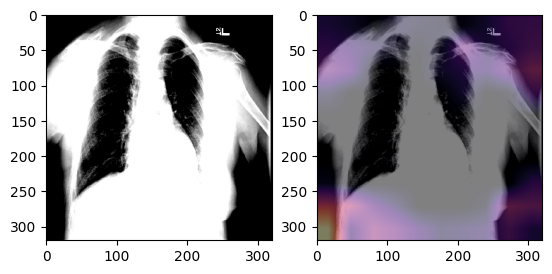

In [48]:
### OUR CODE ###
# do a plot for every class [0, 14] an image can be predicted to be and the corresponding plots with the heatmap over it
def plot_image_heatmap(im, cam):
    fig, axs = plt.subplots(nrows=1, ncols=2)
    axs[0].imshow(im[0])
    axs[1].imshow(im[0], cmap='gray')
    axs[1].imshow(cam, cmap='magma', alpha=0.5)
    plt.show()

# Iterate over class indices [0, 14]
mean, std = get_mean_std_per_batch(train_df, H=320, W=320)
im = load_image_normalize(im_path, mean, std)
for class_index in range(14):
    cam = grad_cam(model, im, class_index, 'conv5_block16_concat', 320)
    plot_image_heatmap(im, cam)

1/1 [==============================] - 5s 5s/step
[[0.44449902 0.9020265  0.6285588  0.3981204  0.56015706 0.41149718
  0.2385473  0.56844157 0.8699316  0.6414832  0.37963632 0.10169895
  0.4062304  0.5347075 ]]
Ground Truth:  Emphysema, Infiltration, Pneumothorax, Pleural_Thickening
Generating gradcam for class Cardiomegaly (p=0.44)
Generating gradcam for class Effusion (p=0.63)
Generating gradcam for class Atelectasis (p=0.57)


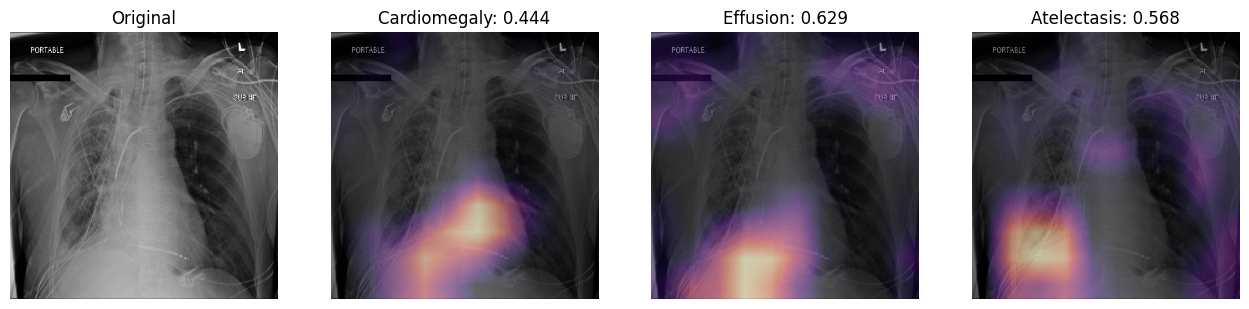

In [49]:
### OUR CODE ###
image_filename = '00000013_005.png'
assert image_filename in train_df['Image Index'].values, "The filename must be the name of an image in the training set"
labels_to_show = ['Atelectasis', 'Cardiomegaly', 'Effusion']
compute_gradcam(model, image_filename, mean, std, IMAGE_DIR, train_df, labels, labels_to_show)